In [1]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault, rcParams
import numpy as np
import os
%matplotlib inline

In [2]:
# plt.style.use('~/C3MP/plot_style.txt')

In [3]:
fig_dir = '/home/kilian/C3MP/simulations/figures/'

In [4]:
columnwidth = 443.5784
# def get_figsize(columnwidth=443.5784, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
#     """ Parameters:
#     - wf [float]:  width fraction in columnwidth units
#     - hf [float]:  height fraction in columnwidth units.
#                    Set by default to golden ratio.
#     - columnwidth [float]: width of the column in latex. Get this from LaTeX 
#                            using \showthe\columnwidth
#     Returns:  [fig_width,fig_height]: that should be given to matplotlib
#     """
#     fig_width_pt = columnwidth*wf 
#     inches_per_pt = 1.0/72.27               # Convert pt to inch
#     fig_width = fig_width_pt*inches_per_pt  # width in inches
#     fig_height = fig_width*hf      # height in inches
#     return [fig_width, fig_height]

# get_figsize()

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fig_sizes = set_size(columnwidth)
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['axes.labelsize'] = 12

In [5]:
plt.rcParams["figure.dpi"]=150
plt.rcParams["figure.facecolor"]="white"
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['axes.labelsize'] = 12
plt.rcParams.update({'font.size': 8})
# plt.rcParams["figure.figsize"]=(8,6)
# gfigsize = figsize=get_figsize(columnwidth, wf=1.0, hf=0.3)

In [6]:
# plot_bands_pdos("C6H4_C6H4", ylimit=[0,1], symmpts='GX', plotnhighest=4)

In [6]:
b_blocks = ["C6H4_C6H4", "C6H4_C5NH3", "C6H4_C5NH3a", "C5NH3_C5NH3", "C5NH3_C5NH3a",
            "C5NH3a_C5NH3a", "CH_CH", "CH_N", "CH_O", "N_O", "O_O"]

c_blocks = ["C6H3_C6H3", "C6H3_C3N3", "C6H3_B3O3", "C3N3_C3N3", "C3N3_B3O3", "B3O3_B3O3",
            "C_C", "C_N"]

In [7]:
def get_vacuum_energy(prefix, conf="B", avg_type='local'):
    
    outfile = f"/scratch/kilian/out/conf_{conf}/{prefix}/avg.dat"
    
    with open(outfile) as f:
        lines = f.readlines()
        
    if avg_type == 'local':
        avg_ind = 1
    else:
        avg_ind = 2

    max_f = float(lines[0].split()[avg_ind])
    min_f = float(lines[0].split()[avg_ind])
    for line in lines:
        V = float(line.split()[avg_ind])
        if V > max_f:
            max_f = V
        if V < min_f:
            min_f = V
            
    min_f *= 13.605698
    max_f *= 13.605698
#    print('vac:', round(max_f,4))
    return round(max_f,4)

def get_symm_pt(prefix, conf, spec_path=None, plot_brouillon=False):
    outfile = f"/scratch/kilian/out/conf_{conf}/{prefix}/{prefix}_bands.out"
    
    with open(outfile) as f:
        lines = f.readlines()
    
    coords = []
    for line in lines:
        if "high-symmetry point:" in line:
            coords.append(float(line.split(' ')[-1]))
            
    
    relax = f"/scratch/kilian/out/conf_{conf}/{prefix}/{prefix}_relax.pwo"
    atoms = read(relax, format='espresso-out')

    lat = atoms.cell.get_bravais_lattice()
    pts_list = lat.get_special_points()
    pts = ''.join([str(item) for item in pts_list])
    path = list(atoms.cell.bandpath(pts, npoints=100).path)
    
    if plot_brouillon == True:
        atoms.cell.bandpath(pts, npoints=100).plot()
        plt.show()
    
    if spec_path == None:
        return dict(zip(path, coords))
    else:
        my_path = {}
        for i,p in enumerate(spec_path):
            my_path[spec_path[i]] = coords[i]
        return my_path
    
def get_el_orb_pdos(pref, conf='B', element=None, orb='s'):
    
    ## find the files
    out_dir = f'/scratch/kilian/out/conf_{conf}/{pref}/'
    files = [f for f in os.listdir(out_dir) if f'({element})' in f\
                                             and f'({orb})' in f]
    
    if orb == 's':
        _, pdos = data_loader(out_dir+files[0])
        for file in files[1:]:
            _, pd = data_loader(out_dir+file)
            pdos = [sum(x) for x in zip(pdos, pd)]
    elif orb == 'p':
        _, (pdosz,pdosx,pdosy) = data_loader(out_dir+files[0])
        for file in files[1:]:
            _, (pz,px,py) = data_loader(out_dir+file)
            pdosz = [sum(x) for x in zip(pdosz, pz)]
            pdosx = [sum(x) for x in zip(pdosx, px)]
            pdosy = [sum(x) for x in zip(pdosy, py)]
        pdos = (pdosz, pdosx, pdosy)
    return pdos

def get_at_orb_pdos(pref, conf='B', element=None, orb='s'):
    
    ## find the files
    out_dir = f'/scratch/kilian/out/conf_{conf}/{pref}/'
    #files = [f for f in os.listdir(out_dir) if f'({element})' in f\
    #                                         and f'({orb})' in f]
    
    if orb == 's':
        _, pdos = data_loader(out_dir+files[0])
#        print(pdos)
    elif orb == 'p':

        _, (pz,px,py) = data_loader(out_dir+file)
        pdosz = [sum(x) for x in zip(pdosz, pz)]
        pdosx = [sum(x) for x in zip(pdosx, px)]
        pdosy = [sum(x) for x in zip(pdosy, py)]
        pdos = (pdosz, pdosx, pdosy)
        
    return pdos
    
def get_fermi_energy(pref, conf='B'):
    
    scf_path = f"/scratch/kilian/out/conf_{conf}/{pref}/{pref}_scf.pwo"
    with open(scf_path) as file:
        filedata = file.readlines()
        
    for line in filedata:
        if "the Fermi energy is" in line:
            e_fermi = float(line.split(" ")[-2])
            return (e_fermi)
        
        elif "highest occupied, lowest unoccupied leve" in line:
            highest, lowest = float(line.split("  ")[-2]), float(line.split(" ")[-1])
            return (highest, lowest)
    
get_fermi_energy("C6H3_C6H3", conf="C")

(-3.9587, -1.8386)

In [8]:
# def data_loader(fname):
#     fid = open(fname, "r")
#     data = fid.readlines()
#     fid.close()
#     energy = []
#     pdos = []
#     for row in range(len(data)):
#         data_row = data[row]
#         if (data_row[0][0] != '#'):
#             data_row = data_row[:-1].split('  ')
#             if data_row[0] != '':
#                 energy.append(float(data_row[0]))
#                 pdos.append(float(data_row[2]))
#             else:
#                 energy.append(float(data_row[1]))
#                 pdos.append(float(data_row[3]))
            
#     energy = np.asarray(energy)
#     pdos = np.asarray(pdos)
#     return energy, pdos

# load data
def data_loader(fname):
    fid = open(fname, "r")
    data = fid.readlines()
    fid.close()
    energy = []
    if '(s)' in fname or 'tot' in fname:
        pdos = []
    elif '(p)' in fname:
        pz = []
        px = []
        py = []
    for row in range(len(data)):
        data_row = data[row]
        if (data_row[0][0] != '#'):
            data_row = data_row[:-1].split('  ')
            # for s orbitals:
            if '(s)' in fname:
                if data_row[0] != '':
                    energy.append(float(data_row[0]))
                    pdos.append(float(data_row[2]))
                else:
                    energy.append(float(data_row[1]))
                    pdos.append(float(data_row[3]))
            # for p orbitals there's 3 columns
            elif '(p)' in fname:
                if data_row[0] != '':
                    energy.append(float(data_row[0]))
                    pz.append(float(data_row[2]))
                    px.append(float(data_row[3]))
                    py.append(float(data_row[4]))
                else:
                    energy.append(float(data_row[1]))
                    pz.append(float(data_row[3]))
                    px.append(float(data_row[4]))
                    py.append(float(data_row[5]))
            else:
                if data_row[0] != '':
                    energy.append(float(data_row[0]))
                    pdos.append(float(data_row[2]))
                else:
                    energy.append(float(data_row[1]))
                    pdos.append(float(data_row[3]))
    if '(s)' in fname or 'tot' in fname:
        energy = np.asarray(energy)
        pdos = np.asarray(pdos)
        return energy, pdos
    elif '(p)' in fname:
        energy = np.asarray(energy)
        pz = np.asarray(pz)
        px = np.asarray(px)
        py = np.asarray(py)
        return energy, (pz,px,py)

In [9]:
el_orb = {'H':['s'], 'C':['s','p'], 'N':['s','p'], 'O':['s','p'], 'B':['s','p']}

In [10]:
def plot_atoms_pdos(pref, conf='B', orbs=[], ebounds=None):
    
    es = list(set([c for c in pref if c.isupper()]))
    out_dir = f'/scratch/kilian/out/conf_{conf}/{pref}/'

    fig = plt.figure()
    if ebounds != None:
        plt.xlim(ebounds)
    for f in os.listdir(out_dir):
        if ".pdos_atm#" in f:
            atnum = f.split("#")[1][0:2]
            if not atnum[1].isdigit():
                atnum = atnum[0]
            if '(s)' in f:
                if int(atnum) in orbs['s']:
                    e, pd = data_loader(out_dir+f)
                    plt.plot(e,pd, label=atnum+' s')
            else:
                e, (pz,px,py) = data_loader(out_dir+f)
                if int(atnum) in orbs['pz']:
                    if int(atnum) == 4:
                        label = "C bonded 3 Cs"
                    elif int(atnum) == 1:
                        label = "C bonded to 2 Cs, 1 H"
                    else:
                        label = 69
                    plt.plot(e,pz, label=label)
                if int(atnum) in orbs['px']:
                    plt.plot(e,px, label=atnum+' px')
                if int(atnum) in orbs['py']:
                    plt.plot(e,py, label=atnum+' py')
                    
    plt.title('PDOS for Carbon atoms Near Fermi Level ')
    plt.yticks(color='w')

    plt.xlabel('Energy, (eV)')
    plt.legend()
    plt.savefig(fig_dir+"pdos2atoms.png")

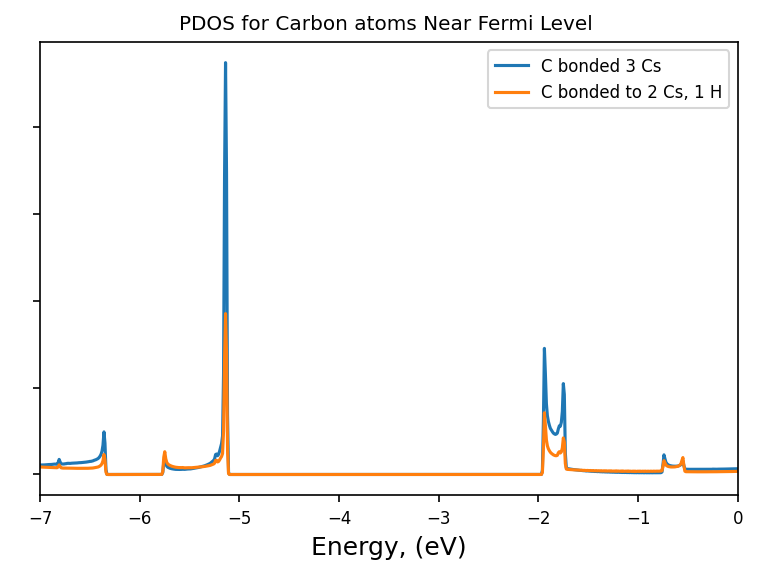

In [11]:
atnums = {'s':[],
          'pz':[1,4],
          'px':[],
          'py':[]}

plot_atoms_pdos("C6H4_C6H4", conf="B", orbs=atnums, ebounds=[-7,0])

In [15]:
def plot_bands_pdos(prefix, conf='B', plot_brouillon=False, ylimit=None, plotnhighest=None, symmpts=None,
                   mytitle=None):
    
    confname=conf[0]
    datadir = f"/scratch/kilian/out/conf_{confname}/"
    data = np.loadtxt(f"{datadir}{prefix}/{prefix}_bands.dat.gnu")
    k = np.unique(data[:, 0])
    bands = np.reshape(data[:, 1], (-1, len(k)))
        
    if conf == "C":
        spec_path = 'GYHG'
    elif conf == "Brr":
        spec_path = "GX"
    else:
        spec_path = None
    symms = get_symm_pt(prefix, confname, plot_brouillon=plot_brouillon, spec_path=spec_path)
    
    e_vacuum = get_vacuum_energy(prefix, conf=confname)
    

    
    fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [2, 1]})

    fig.set_figheight(fig_sizes[1])
    fig.set_figwidth(fig_sizes[0])

    e_fermi = get_fermi_energy(pref=prefix,conf=conf)
    num_below = 0
    for band in range(len(bands)):    
        #e_vacuum = 0
        scaled_band = np.subtract(bands[band, :], e_vacuum)

       # print(scaled_band[0])
        axs[0].plot(k, scaled_band, linewidth=1, alpha=0.5, color='k')
#        if band == 33:
#             print(max(scaled_band))
#        if max(scaled_band) < e_fermi[0]:
#            num_below += 1
#     print('num below fermi: ',num_below)    
    axs[0].set_xlim(min(k), max(k))
    
    if symmpts == None:
        axs[0].set_xticks(ticks= list(symms.values()), \
                labels=list(symms.keys()))
    else:
        axs[0].set_xticks(ticks= list(symms.values()), \
                labels=symmpts)

    if ylimit != None:
        axs[0].set_ylim(ylimit)

        
    for x in symms.values():
        axs[0].axvline(x, linewidth=0.75, color='k', alpha=0.5)
        
    e_fermi = get_fermi_energy(pref=prefix,conf=conf)
#     if e_fermi != None:
#         if isinstance(e_fermi, float):
#             axs[0].axhline(e_fermi-e_vacuum, linewidth=0.75, linestyle='--', color='r', alpha=0.5)
#             axs[1].axhline(e_fermi-e_vacuum, linewidth=0.75, linestyle='--', color='r', alpha=0.5)
#         elif len(e_fermi) == 2:
#             axs[0].axhline(e_fermi[0]-e_vacuum, linewidth=.75, linestyle='--', color='r', alpha=1, label='highest occ')
#             #axs[1].axhline(e_fermi[0], linewidth=0.5, linestyle='--', color='r', alpha=1, label='lowest unocc')
#             axs[0].axhline(e_fermi[1]-e_vacuum, linewidth=.75, linestyle='--', color='r', alpha=1, label='highest occ')
#             #axs[1].axhline(e_fermi[1], linewidth=0.5, linestyle='--', color='r', alpha=1, label='lowest unocc')


    axs[0].set_ylabel('Energy (eV)')
    
    
    
    
    
    ##### pdos #####
    energy, pdos_tot = data_loader(f'/scratch/kilian/out/conf_{conf}/{prefix}/{prefix}_pdos.dat.pdos_tot')
    
    e_vacuum = get_vacuum_energy(prefix, conf=conf)
    energy = np.subtract(energy, e_vacuum)
    orb_pdoss = []
    els = list(set([c for c in prefix if c.isupper()]))

    ## get n highest
    sums = []
    if plotnhighest != None:
        for el in els:
            for orb in el_orb[el]:
                if orb == 's':
                    orb_pdos = get_el_orb_pdos(prefix, conf=conf, element=el, orb=orb)
                    sums.append(sum(orb_pdos))
                elif orb == 'p':
                    (pdosz, pdosx, pdosy) = get_el_orb_pdos(prefix, conf=conf, element=el, orb=orb)
                    sums.append(sum(pdosz))
                    sums.append(sum(pdosx))
                    sums.append(sum(pdosy))
            
    sums.sort()
    for el in els:
        for orb in el_orb[el]:
            if orb == 's':
                orb_pdos = get_el_orb_pdos(prefix, conf=conf, element=el, orb=orb)
                if plotnhighest == None:
                    axs[1].plot(orb_pdos, energy, linewidth=1.5, label=f'{el} {orb}-orbital')
                else:
                    if sum(orb_pdos) >= sums[-plotnhighest]:
                        axs[1].plot(orb_pdos, energy, linewidth=1.5, label=f'{el} {orb}-orbital')
            elif orb == 'p':
                (pdosz, pdosx, pdosy) = get_el_orb_pdos(prefix, conf=conf, element=el, orb=orb)
                if plotnhighest == None:
                    axs[1].plot(pdosz, energy, linewidth=1.5, label=f'{el} {orb}-orbital, Z')
                    axs[1].plot(pdosx, energy, linewidth=1.5, label=f'{el} {orb}-orbital, X')
                    axs[1].plot(pdosy, energy, linewidth=1.5, label=f'{el} {orb}-orbital, Y')
                else:
                    if sum(pdosz) >= sums[-plotnhighest]:
                        axs[1].plot(pdosz, energy, linewidth=1.5, label=f'{el} {orb}-orbital, Z')
                    if sum(pdosx) >= sums[-plotnhighest]:
                        axs[1].plot(pdosx, energy, linewidth=1.5, label=f'{el} {orb}-orbital, X')
                    if sum(pdosy) >= sums[-plotnhighest]:
                        axs[1].plot(pdosy, energy, linewidth=1.5, label=f'{el} {orb}-orbital, Y')

    e_fermi = get_fermi_energy(pref=prefix,conf=conf)
#     if e_fermi != None:
#         if isinstance(e_fermi, float):
#             plt.axhline(e_fermi-e_vacuum, linewidth=0.75, linestyle='--', color='r', alpha=0.5, label='e-fermi')
#         elif len(e_fermi) == 2:
#             axs[1].axhline(e_fermi[0]-e_vacuum, linewidth=.75, linestyle='--', color='r', alpha=.5, label=None)
#             #axs[1].axhline(e_fermi[0], linewidth=0.5, linestyle='--', color='r', alpha=1, label='lowest unocc')
#             axs[1].axhline(e_fermi[1]-e_vacuum, linewidth=.75, linestyle='--', color='r', alpha=.5, label=None)
#             #axs[1].axhline(e_fermi[1], linewidth=0.5, linestyle='--', color='r', alpha=1, label='lowest unocc')

    
#     axs[1].set_xlim([0,3])
#     axs[0].axhline(-.5)
#     axs[0].axhline(-6.9)
    
    #axs[1].plot(pdos_tot, energy, linewidth=0.75, color='k', label=None)
    axs[1].legend(frameon=False)
    axs[1].sharey(axs[0])
    axs[1].yaxis.tick_right()
    fig.subplots_adjust(wspace=0)
    axs[1].set_xticks([])

#    axs[1].set_xlim([0,10])
    if mytitle != None:
        plt.suptitle(mytitle)
    else:
        plt.suptitle(prefix)
#     fig.title(prefix)
    plt.savefig(fig_dir+f'{prefix}_band_pdos_n.png')
    plt.show()
    # fermi energy 

In [1]:
print('n')

n


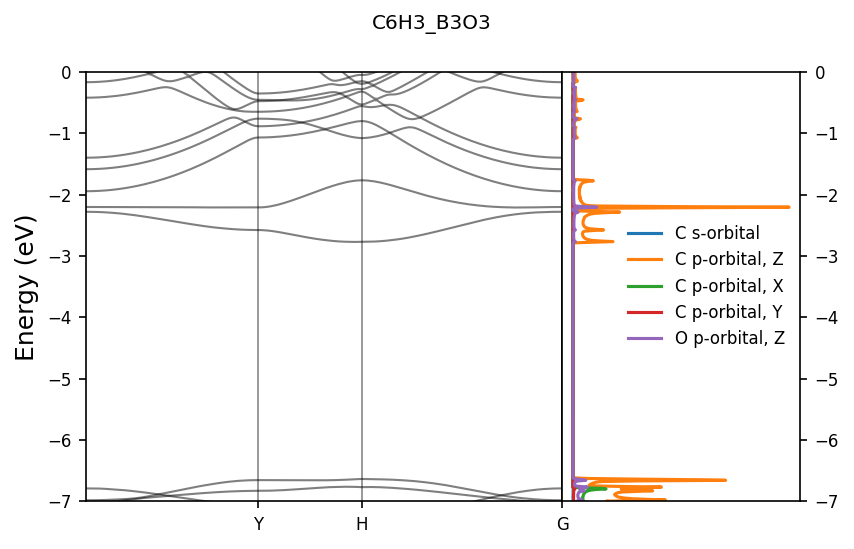

In [31]:
plot_bands_pdos("C6H3_B3O3", conf="C", ylimit=[-7,0], plotnhighest=5)

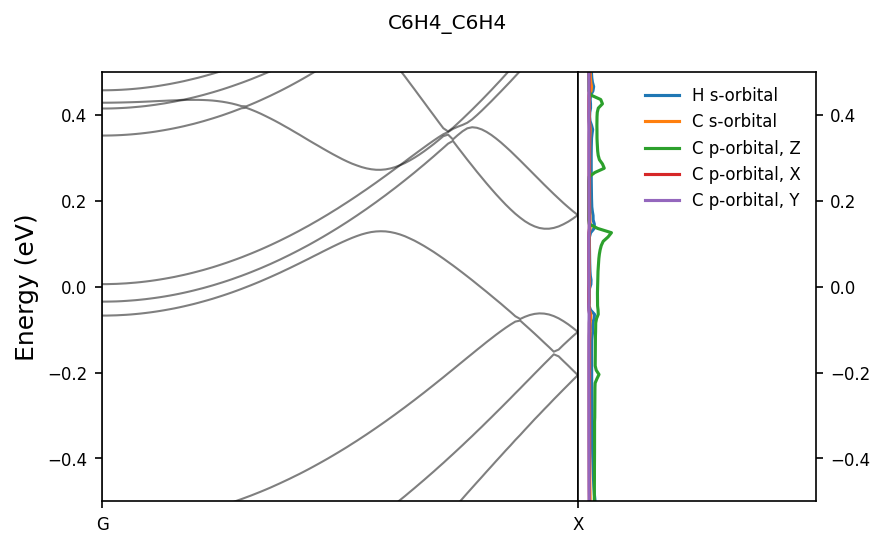

In [20]:
plot_bands_pdos("C6H4_C6H4", symmpts='GX', ylimit=[-0.5,0.5])

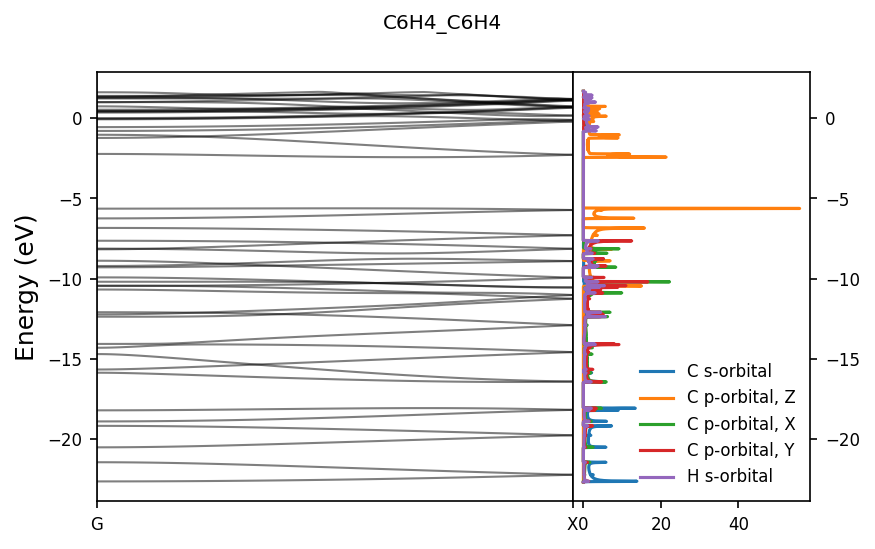

In [38]:
plot_bands_pdos("C6H4_C6H4", symmpts='GX')

vac: 0.0356
0.5778
num below fermi:  28
vac: 0.0356


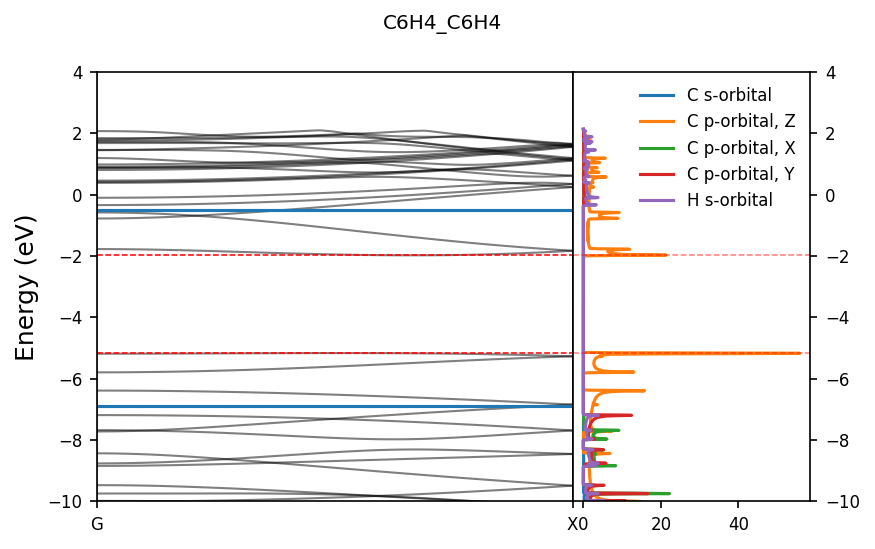

In [20]:
plot_bands_pdos("C6H4_C6H4", ylimit=[-10,1], symmpts='GX')

0.5778


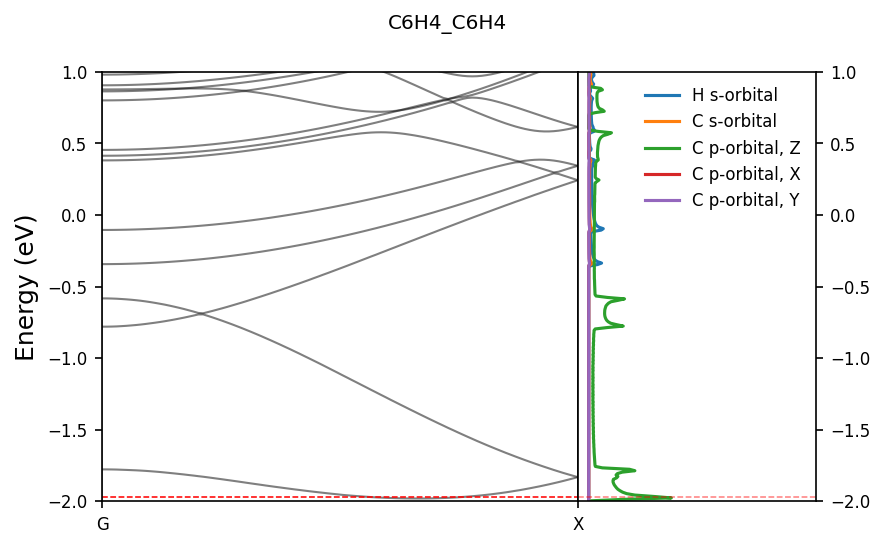

In [13]:
plot_bands_pdos("C6H4_C6H4", ylimit=[-2,1], symmpts='GX')

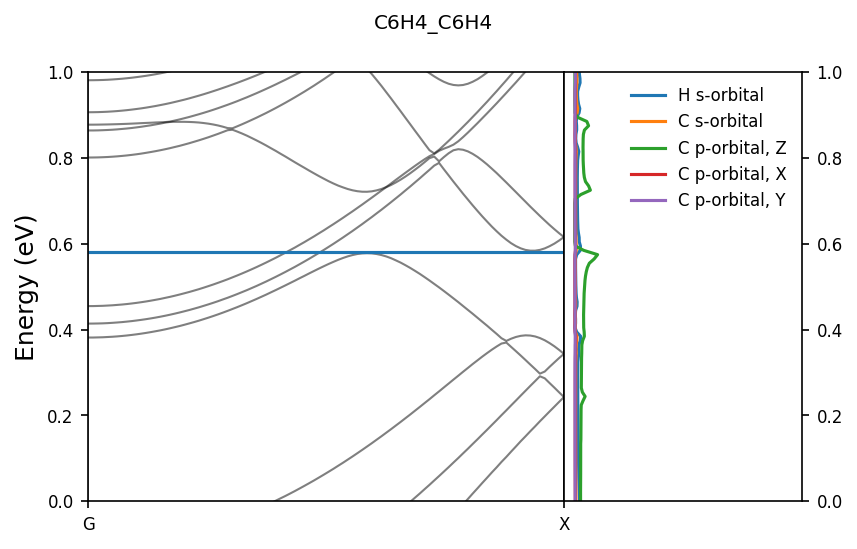

In [47]:
plot_bands_pdos("C6H4_C6H4", ylimit=[0,1], symmpts='GX')

vac: 0.0285
0.2971
vac: 0.0285


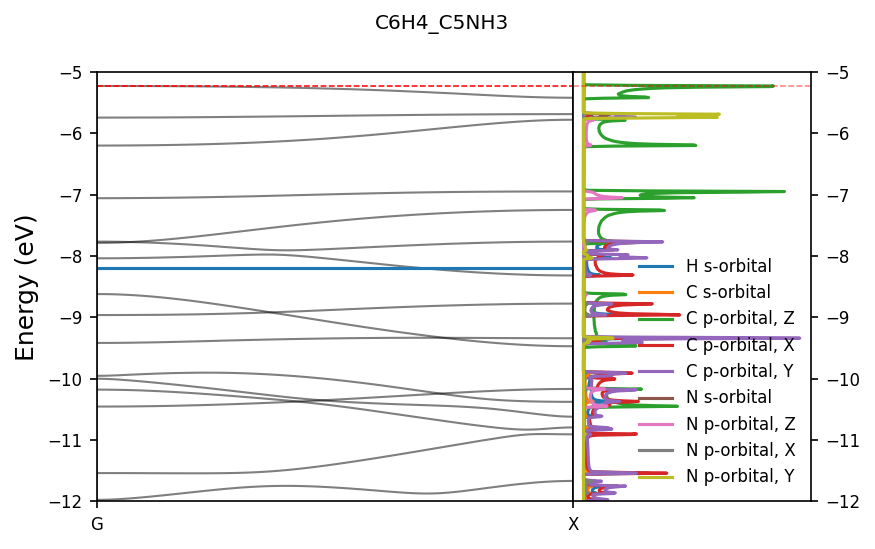

In [28]:
plot_bands_pdos("C6H4_C5NH3", ylimit=[-12,-5], symmpts='GX')

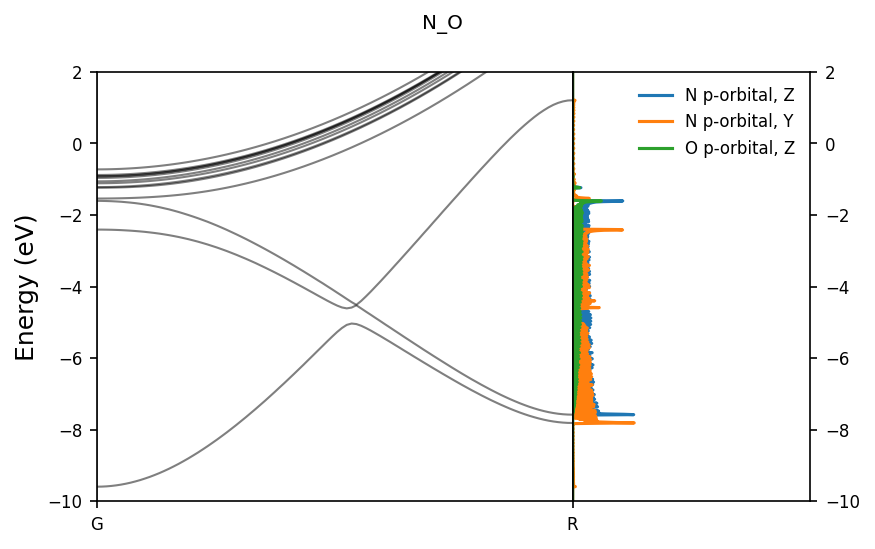

In [17]:
plot_bands_pdos("N_O", ylimit=[-10, 2], plotnhighest=3)

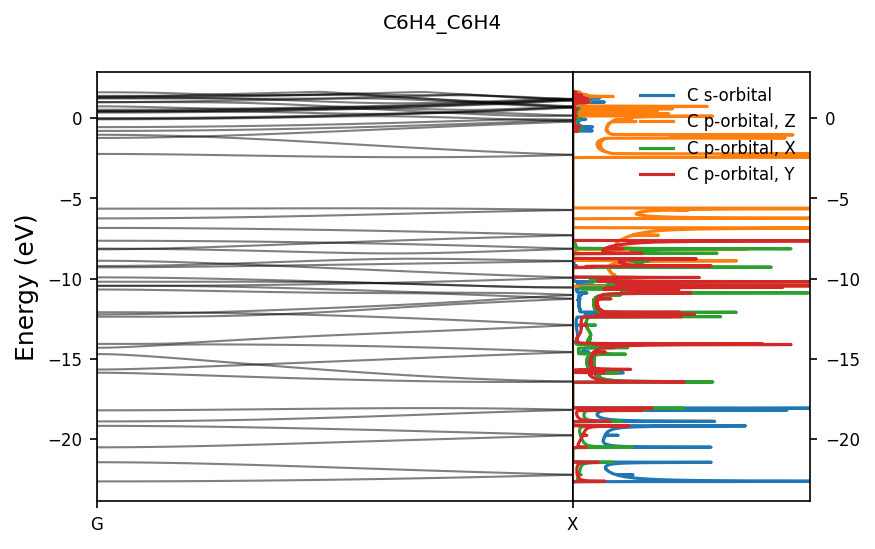

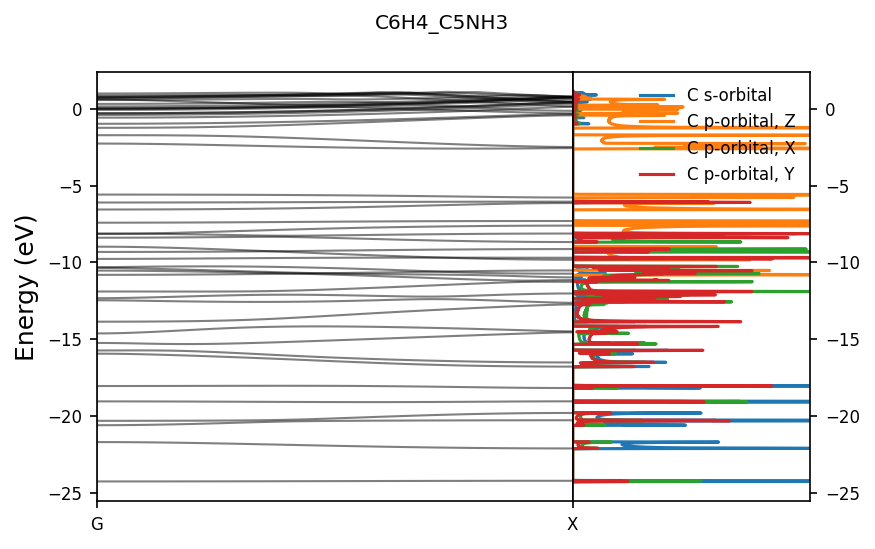

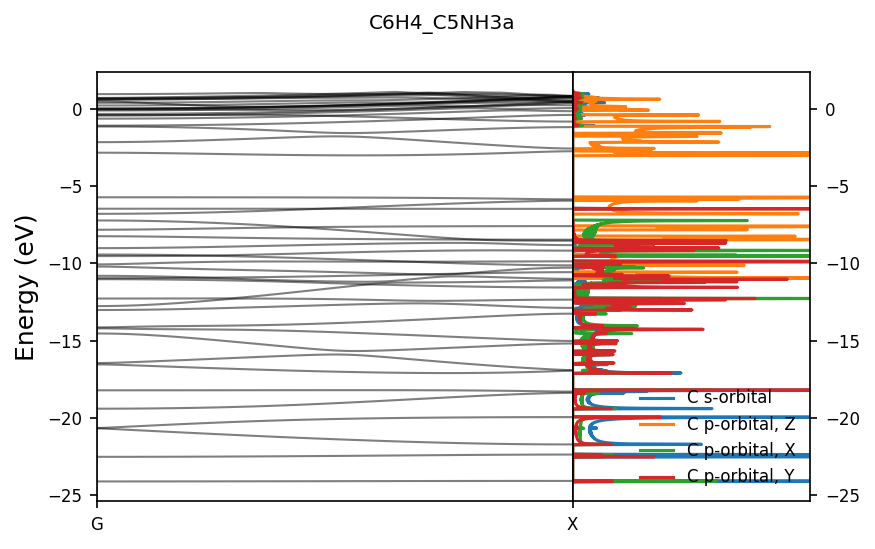

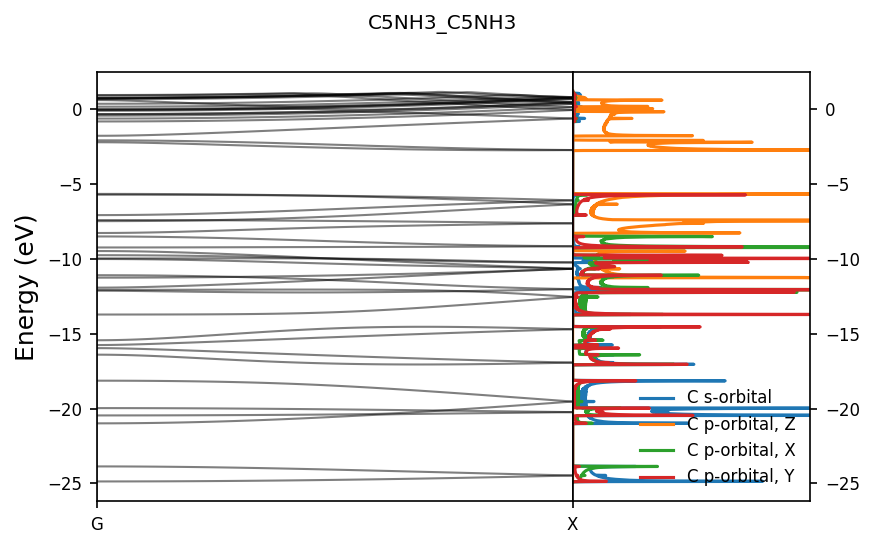

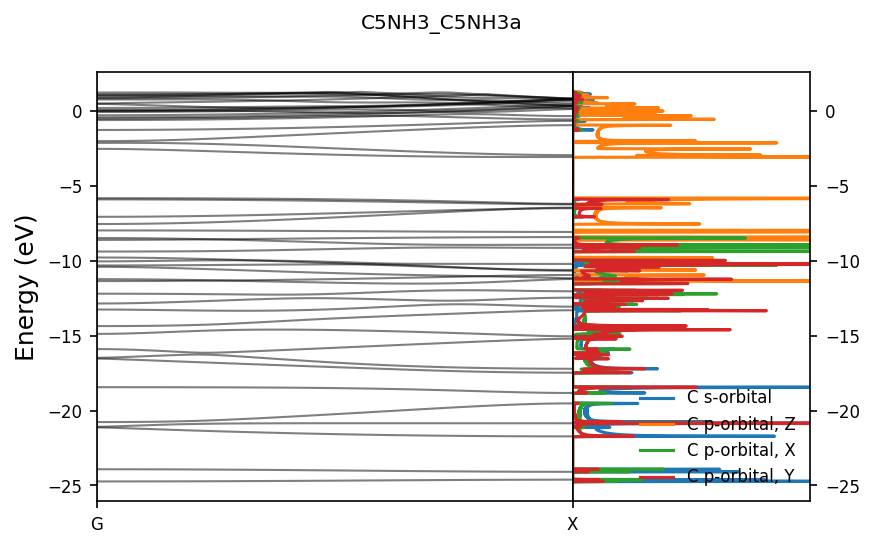

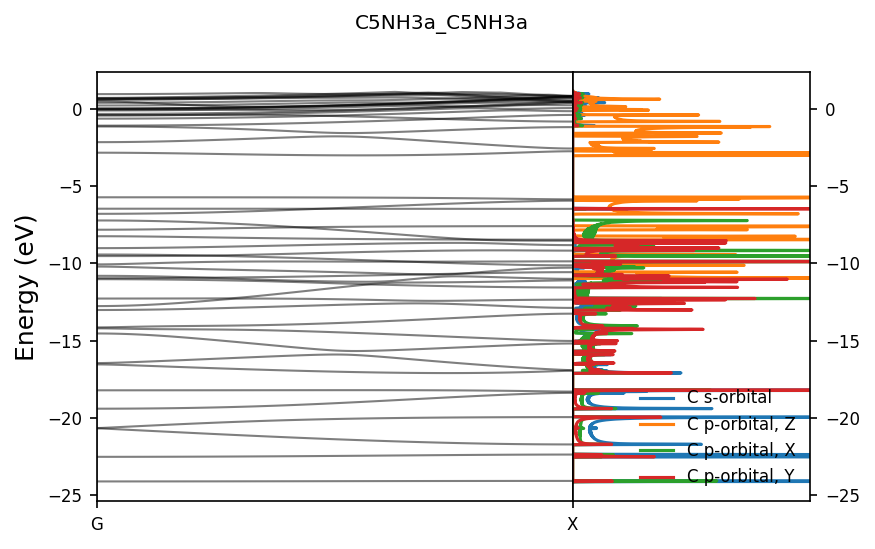

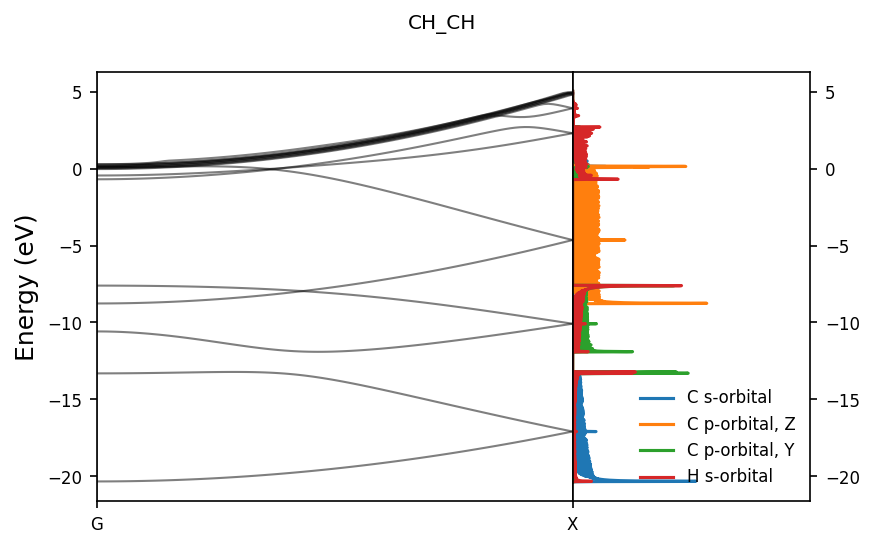

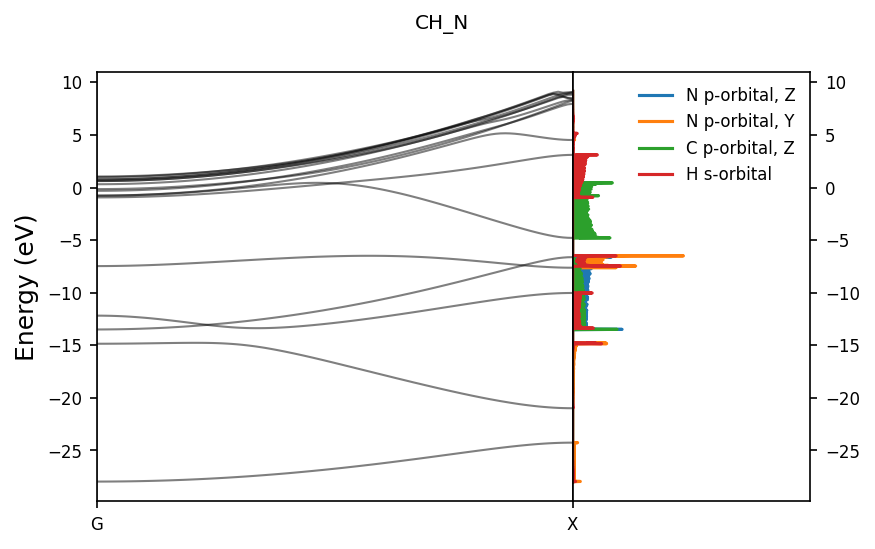

CH_O


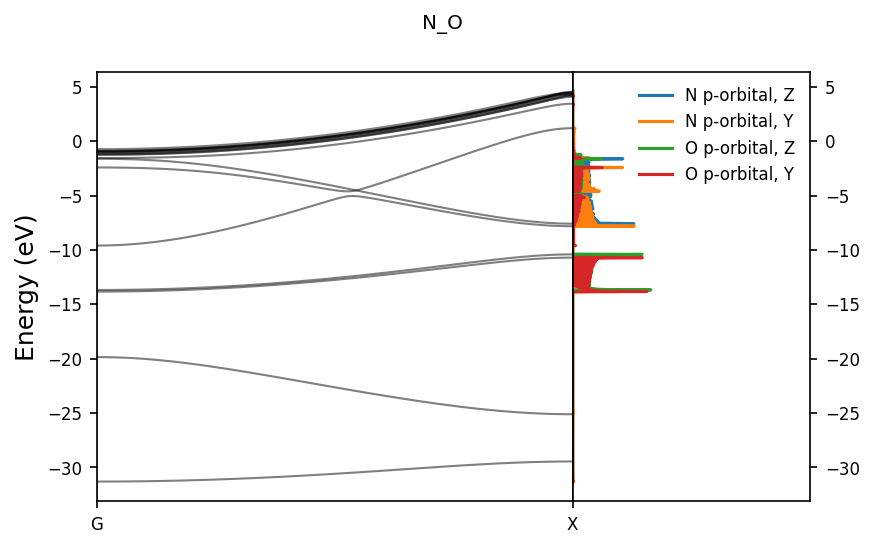

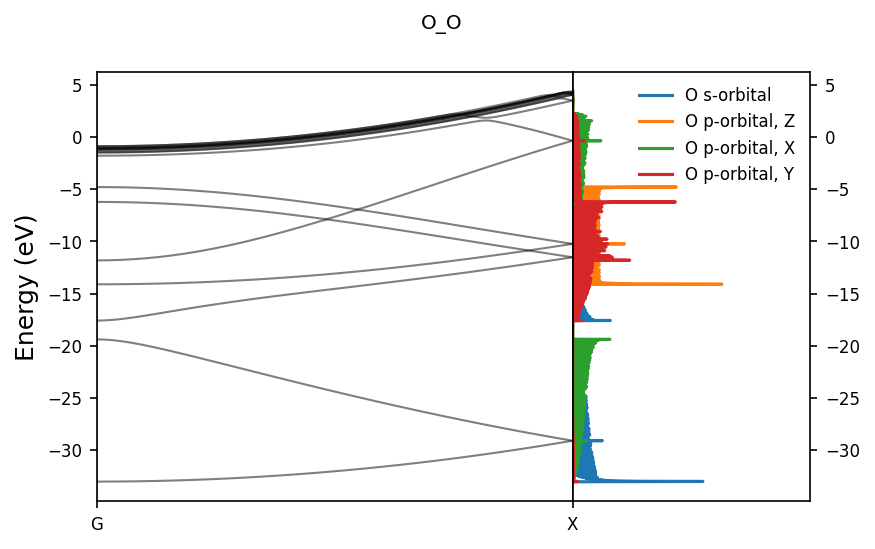

In [18]:
for block in b_blocks:
    try:
        plot_bands_pdos(block, symmpts='GX', plotnhighest=4)
    except:
        print(block)

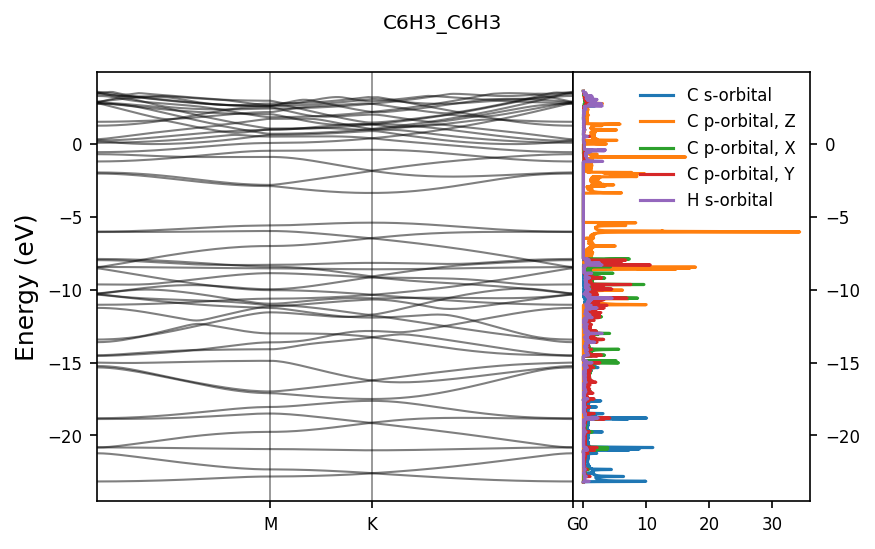

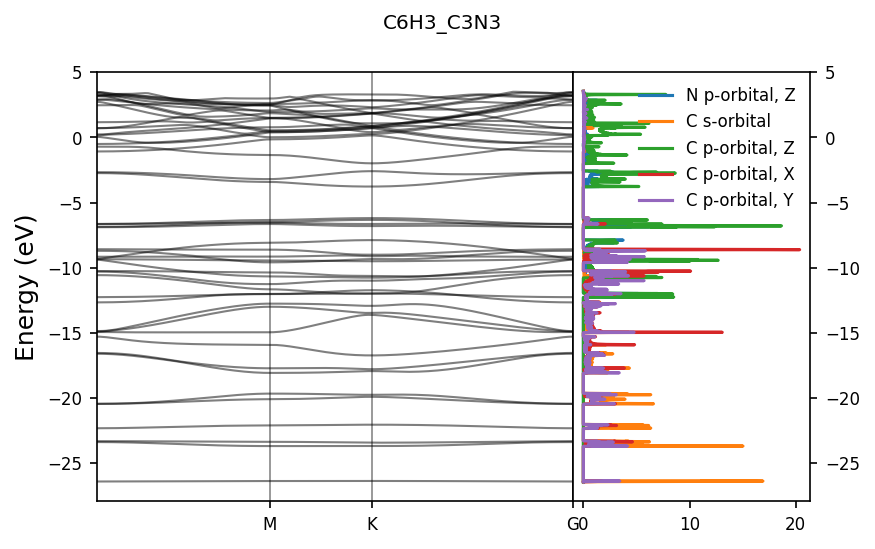

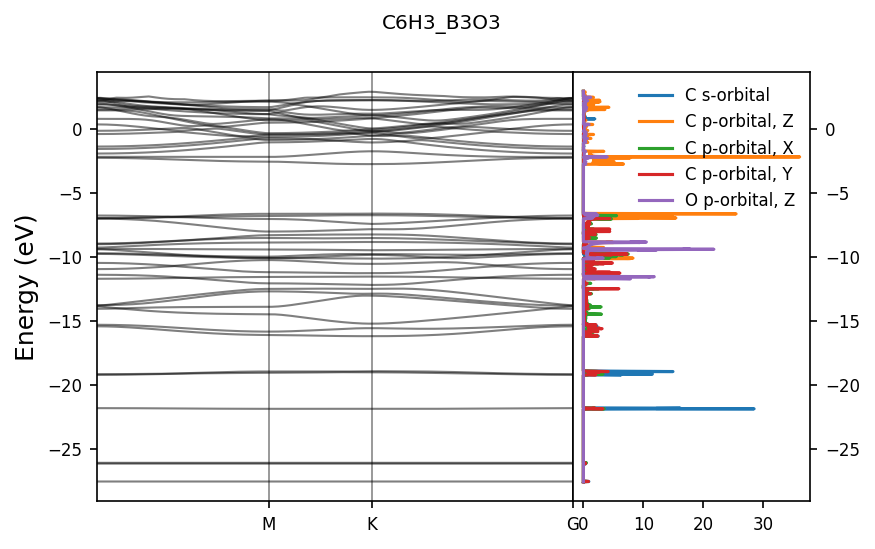

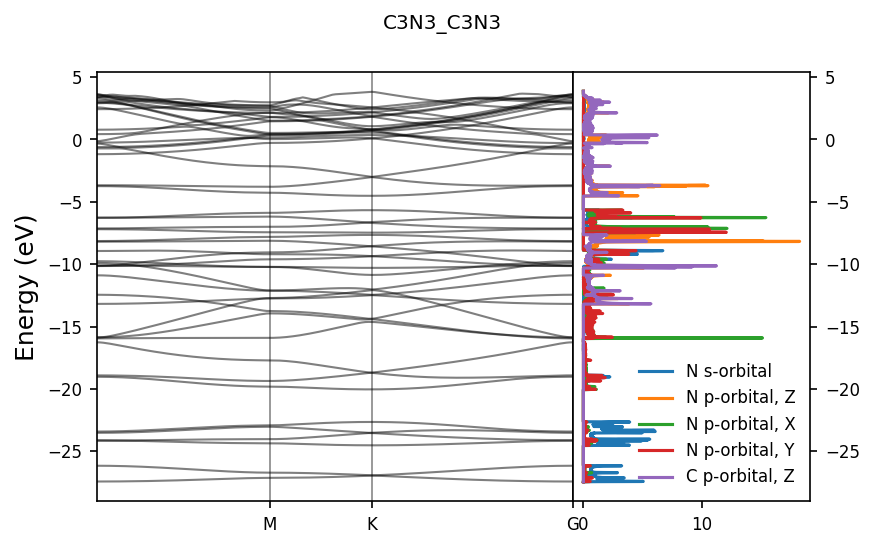

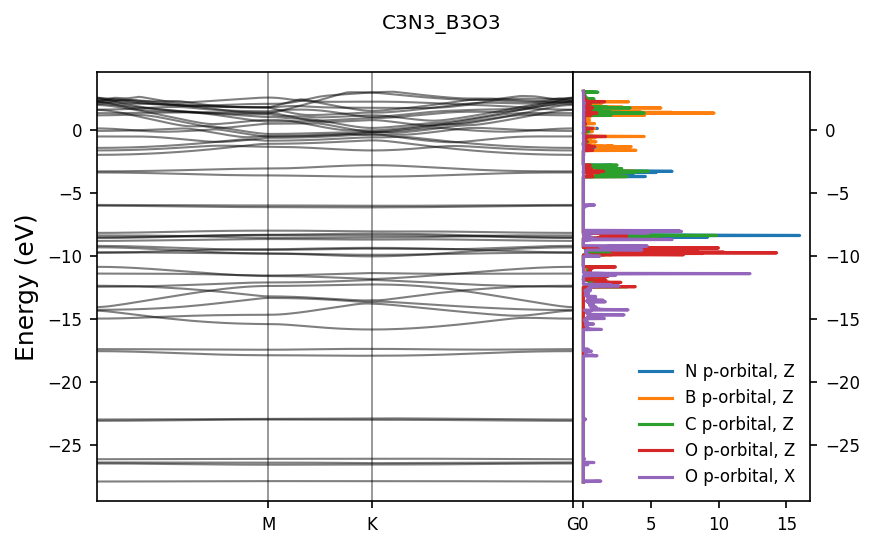

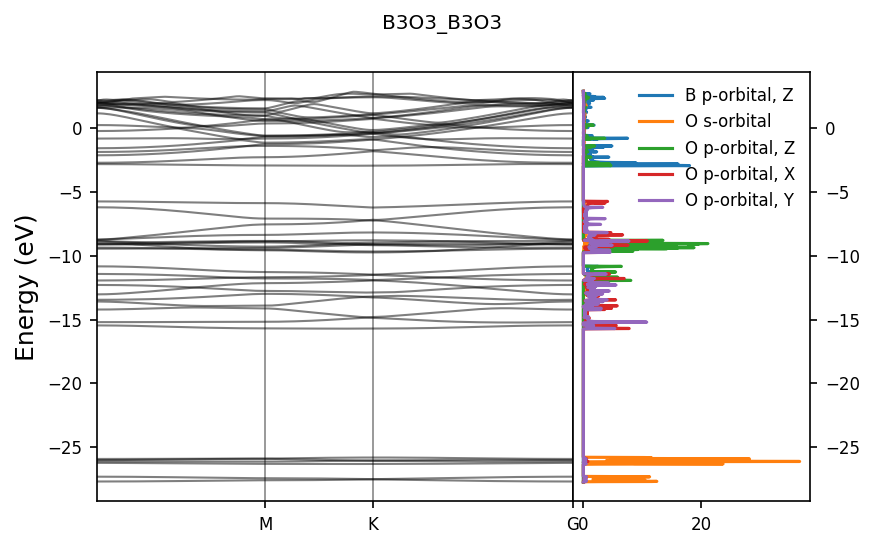

C_C


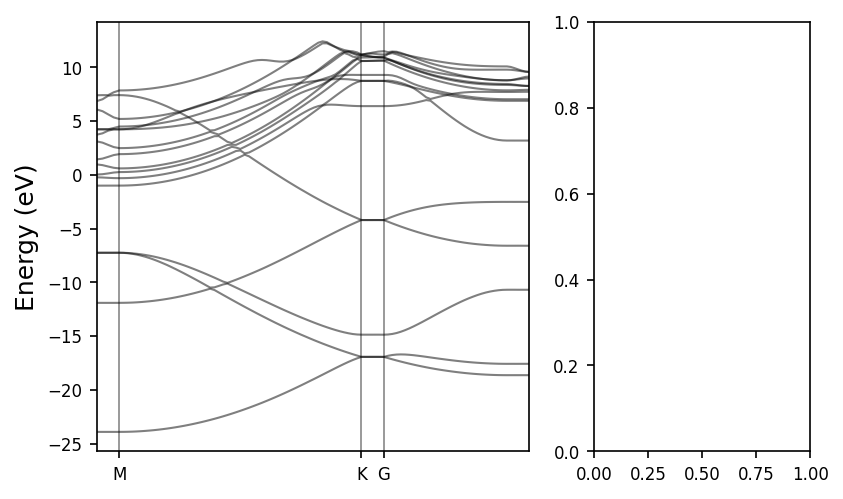

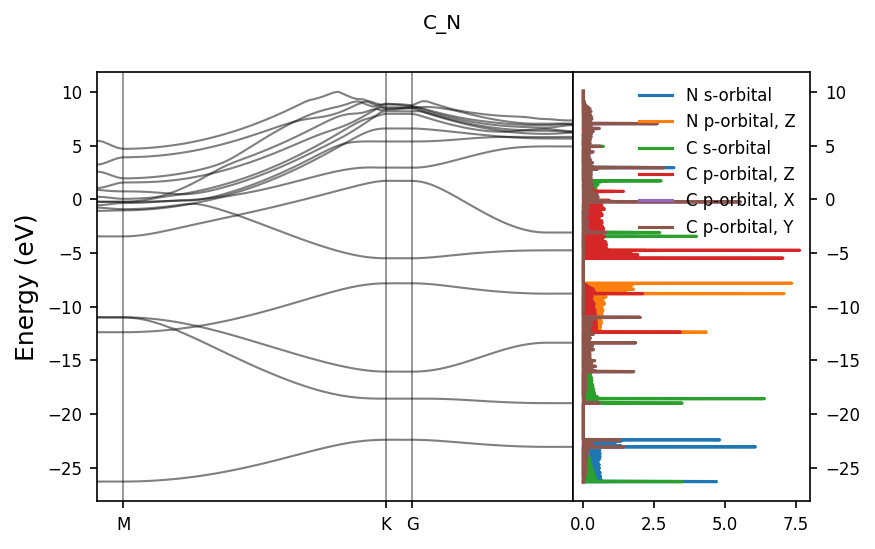

In [14]:
for block in c_blocks:
    try:
        plot_bands_pdos(block, conf='C', symmpts='GMK', plotnhighest=5)
    except:
        print(block)